# Wine Quality Dataset - Precise GP

In [1]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
import torch
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
from utils import *
import pandas as pd
import os
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 
tf.random.set_seed(42)
np.random.seed(42)

2023-04-05 09:13:26.254324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


## Import the Wine Dataset

In [2]:
def csv_to_pth(name, csv_path, pth_path):
    def dataframe_to_arrays(df):
        df_ = df.copy(deep=True)
        X = np.atleast_2d(df_[input_cols].to_numpy())
        Y = np.atleast_2d(df_[output_cols].to_numpy().reshape(-1,1))
        return X, Y
    dataframe_raw = pd.read_csv(csv_path)
    dataframe_raw.head()
    input_cols = list(dataframe_raw.columns)[:-1]
    output_cols = list(dataframe_raw.columns)[-1]
    X, Y = dataframe_to_arrays(dataframe_raw)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    inputs = torch.tensor(X, dtype=torch.float64)
    targets = torch.tensor(Y, dtype=torch.float64)
    torch.save([inputs, targets], pth_path + name + '.pth')
    return input_cols, output_cols
input_cols, output_cols = csv_to_pth("wine", "data/winequality-red.csv", "data/")

In [34]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('wine', 42)
D = X_train.shape[1]

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(66,)",float64,"[0.30151, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
--- Final values ---
Variance: 1.414


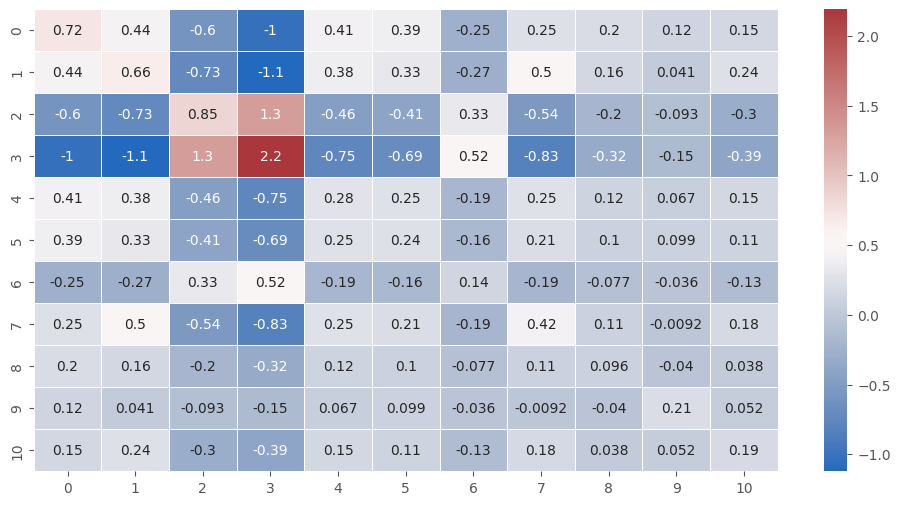

In [6]:
model_GPR_LRBF = train_GPR_LRBF_model(X_train=X_train, Y_train=Y_train, prior=None, iprint=True)

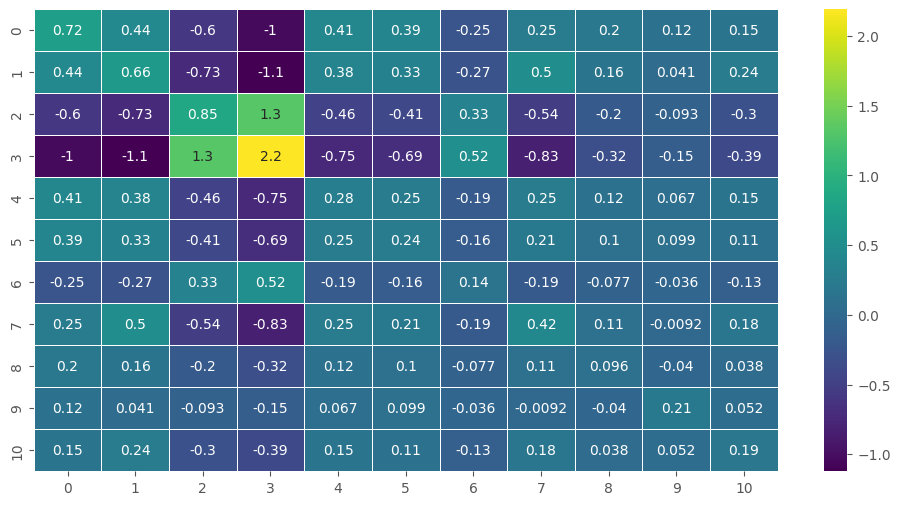

In [7]:
Lambda = model_GPR_LRBF.kernel.get_Lambda()
plot_matrix(M=Lambda, cmap='viridis', correlation=False)

In [32]:
r = 1
def regularized_training_loss():
    return -(model_GPR_LRBF.log_marginal_likelihood() + model_GPR_LRBF.log_prior_density()) + r * tf.norm(model_GPR_LRBF.kernel.get_Lambda(), ord=1)


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(66,)",float64,"[1., 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
--- Final values ---
Variance: 1.137


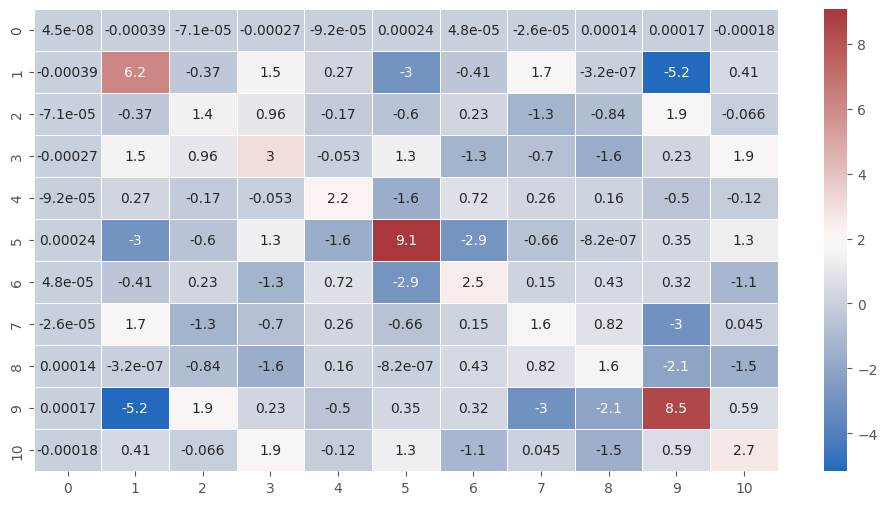

In [42]:
# Define the kernel 
reg = 0.2
lengthscales = tf.constant([1]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)
LRBF = LambdaRBF(Lambda_L_array, 1.0)
model_GPR_LRBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF,
)
gpflow.utilities.print_summary(model_GPR_LRBF, fmt="notebook")
print('--- Initial values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
print('Lambda diagonal: ', tf.linalg.diag_part(LRBF.get_Lambda()).numpy())
opt = gpflow.optimizers.Scipy()
if reg > 0:
    def regularized_training_loss():
        return -(model_GPR_LRBF.log_marginal_likelihood() + model_GPR_LRBF.log_prior_density()) + reg * tf.norm(model_GPR_LRBF.kernel.get_Lambda(), ord=1)
    opt.minimize(regularized_training_loss, model_GPR_LRBF.trainable_variables)
else:
    opt.minimize(model_GPR_LRBF.training_loss(), model_GPR_LRBF.trainable_variables)
print('--- Final values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
plot_matrix(LRBF.get_Lambda())

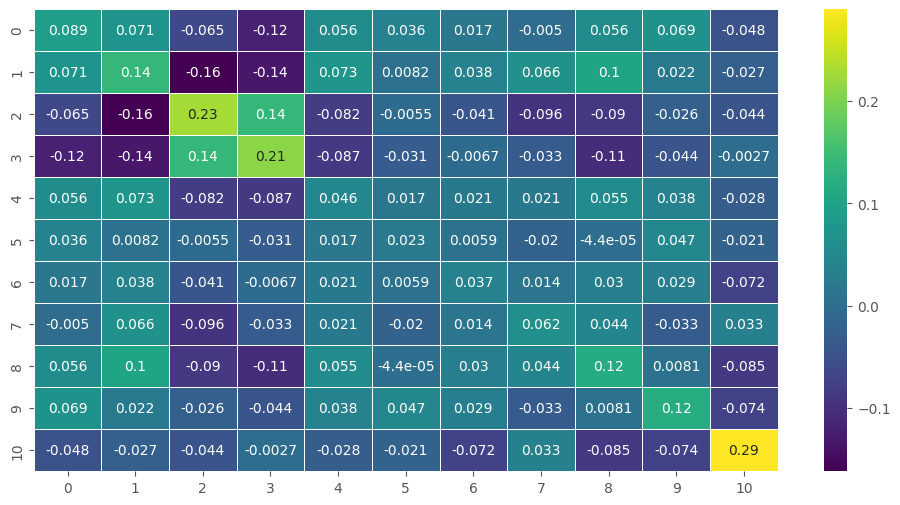

In [39]:
plot_matrix(LRBF.get_Lambda(), cmap='viridis')